In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
import matplotlib.patheffects as pe
from highlight_text import fig_text
from adjustText import adjust_text
from tabulate import tabulate
import matplotlib.style as style
import unicodedata
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

style.use('fivethirtyeight')

from PIL import Image
import urllib
import os
import math
from PIL import Image
import matplotlib.image as image
pd.options.display.max_columns = None

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warnin

In [2]:
keepers = ['GK']
defenders = ["DF",'DF,MF']
wing_backs = ['FW,DF','DF,FW']
midfielders = ['MF,DF','MF']
forwards = ['FW','MF,FW',"FW,MF"]
def position_grouping(x):
    if x in keepers:
        return "GK"
    elif x in defenders:
        return "Defender"
    elif x in wing_backs:
        return "Wing-Back"
    elif x in midfielders:
        return "Central Midfielders"
    elif x in forwards:
        return "Forwards"
    else:
        return "unidentified position"

In [3]:
fbref_passing = 'https://fbref.com/en/comps/Big5/passing/players/Big-5-European-Leagues-Stats'
fbref_shooting = 'https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats'
fbref_pass_type = 'https://fbref.com/en/comps/Big5/passing_types/players/Big-5-European-Leagues-Stats'
fbref_defence = 'https://fbref.com/en/comps/Big5/defense/players/Big-5-European-Leagues-Stats'
fbref_gca = 'https://fbref.com/en/comps/Big5/gca/players/Big-5-European-Leagues-Stats'
fbref_poss = 'https://fbref.com/en/comps/Big5/possession/players/Big-5-European-Leagues-Stats'
fbref_misc = 'https://fbref.com/en/comps/Big5/misc/players/Big-5-European-Leagues-Stats'

In [14]:
def create_full_stats_db(fbref_passing,fbref_shooting,fbref_pass_type,fbref_defence,fbref_gca,fbref_poss,fbref_misc):
    # Passing columns 
    pass_ = fbref_passing
    page =requests.get(pass_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(pass_).text.replace('<!--', '').replace('-->', '')
    pass_df = pd.read_html(html_content)
    pass_df[-1].columns = pass_df[-1].columns.droplevel(0)
    pass_stats = pass_df[-1]
    pass_prefixes = {1: 'Total - ', 2: 'Short - ', 3: 'Medium - ', 4: 'Long - '}
    pass_column_occurrences = {'Cmp': 0, 'Att': 0, 'Cmp%': 0}
    pass_new_column_names = []
    for col_name in pass_stats.columns:
        if col_name in pass_column_occurrences:
            pass_column_occurrences[col_name] += 1
            prefix = pass_prefixes[pass_column_occurrences[col_name]]
            pass_new_column_names.append(prefix + col_name)
        else:
            pass_new_column_names.append(col_name)
    pass_stats.columns = pass_new_column_names
    pass_stats = pass_stats[pass_stats['Player'] != 'Player']

    # Shooting columns 
    shot_ = fbref_shooting
    page =requests.get(shot_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(shot_).text.replace('<!--', '').replace('-->', '')
    shot_df = pd.read_html(html_content)
    shot_df[-1].columns = shot_df[-1].columns.droplevel(0) # drop top header row
    shot_stats = shot_df[-1]
    shot_stats = shot_stats[shot_stats['Player'] != 'Player']    



    # Pass Type columns 
    pass_type = fbref_pass_type
    page =requests.get(pass_type)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(pass_type).text.replace('<!--', '').replace('-->', '')
    pass_type_df = pd.read_html(html_content)
    pass_type_df[-1].columns = pass_type_df[-1].columns.droplevel(0) # drop top header row
    pass_type_stats = pass_type_df[-1]
    pass_type_stats = pass_type_stats[pass_type_stats['Player'] != 'Player']


    # GCA columns 
    gca_ = fbref_gca
    page =requests.get(gca_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(gca_).text.replace('<!--', '').replace('-->', '')
    gca_df = pd.read_html(html_content)
    gca_df[-1].columns = gca_df[-1].columns.droplevel(0)
    gca_stats = gca_df[-1]
    gca_prefixes = {1: 'SCA - ', 2: 'GCA - '}
    gca_column_occurrences = {'PassLive': 0, 'PassDead': 0, 'TO%': 0, 'Sh': 0, 'Fld': 0, 'Def': 0}
    gca_new_column_names = []
    for col_name in gca_stats.columns:
        if col_name in gca_column_occurrences:
            gca_column_occurrences[col_name] += 1
            prefix = gca_prefixes[gca_column_occurrences[col_name]]
            gca_new_column_names.append(prefix + col_name)
        else:
            gca_new_column_names.append(col_name)
    gca_stats.columns = gca_new_column_names
    gca_stats = gca_stats[gca_stats['Player'] != 'Player']
    

    # Defense columns 
    defence_ = fbref_defence
    page =requests.get(defence_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(defence_).text.replace('<!--', '').replace('-->', '')
    defence_df = pd.read_html(html_content)
    defence_df[-1].columns = defence_df[-1].columns.droplevel(0) # drop top header row
    defence_stats = defence_df[-1]
    rename_columns = {
    'Def 3rd': 'Tackles - Def 3rd',
    'Mid 3rd': 'Tackles - Mid 3rd',
    'Att 3rd': 'Tackles - Att 3rd',
    'Blocks': 'Total Blocks',
    'Sh': 'Shots Blocked',
    'Pass': 'Passes Blocked'}
    defence_stats.rename(columns = rename_columns, inplace=True)
    defence_prefixes = {1: 'Total - ', 2: 'Dribblers- '}
    defence_column_occurrences = {'Tkl': 0}
    new_column_names = []
    for col_name in defence_stats.columns:
        if col_name in defence_column_occurrences:
            defence_column_occurrences[col_name] += 1
            prefix = defence_prefixes[defence_column_occurrences[col_name]]
            new_column_names.append(prefix + col_name)
        else:
            new_column_names.append(col_name)
    defence_stats.columns = new_column_names
    defence_stats = defence_stats[defence_stats['Player'] != 'Player']


    # possession columns 
    poss_ = fbref_poss
    page =requests.get(poss_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(poss_).text.replace('<!--', '').replace('-->', '')
    poss_df = pd.read_html(html_content)
    poss_df[-1].columns = poss_df[-1].columns.droplevel(0) # drop top header row
    poss_stats = poss_df[-1]
    rename_columns = {
    'TotDist': 'Carries - TotDist',
    'PrgDist': 'Carries - PrgDist',
    'PrgC': 'Carries - PrgC',
    '1/3': 'Carries - 1/3',
    'CPA': 'Carries - CPA',
    'Mis': 'Carries - Mis',
    'Dis': 'Carries - Dis',
    'Att': 'Take Ons - Attempted'  }
    poss_stats.rename(columns=rename_columns, inplace=True)
    poss_stats = poss_stats[poss_stats['Player'] != 'Player']


    # misc columns 
    misc_ = fbref_misc
    page =requests.get(misc_)
    soup = BeautifulSoup(page.content, 'html.parser')
    html_content = requests.get(misc_).text.replace('<!--', '').replace('-->', '')
    misc_df = pd.read_html(html_content)
    misc_df[-1].columns = misc_df[-1].columns.droplevel(0) # drop top header row
    misc_stats = misc_df[-1]
    misc_stats = misc_stats[misc_stats['Player'] != 'Player']

    index_df = misc_stats[['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s']]

    data_frames = [poss_stats, misc_stats, pass_stats ,defence_stats, shot_stats, gca_stats, pass_type_stats]
    for df in data_frames:
        if df is not None:  # Checking if the DataFrame exists
            df.drop(columns=['Matches', 'Rk', 'Comp'], inplace=True, errors='ignore')
            df.dropna(axis=0, how='any', inplace=True)

            index_df = pd.merge(index_df, df, on=['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s'], how='left')
    index_df["position_group"] = index_df.Pos.apply(lambda x: position_grouping(x))  

    index_df.fillna(0, inplace=True)

    non_numeric_cols = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'position_group']
    
    def clean_non_convertible_values(value):
        try:
            return pd.to_numeric(value)
        except (ValueError, TypeError):
            return np.nan

    index_df = index_df.reset_index()

    # Iterate through each column, converting non-numeric columns to numeric
    for col in index_df.columns:
        if col not in non_numeric_cols:
            index_df[col] = index_df[col].apply(clean_non_convertible_values)

    
    return index_df



In [15]:
def per_90fi(dataframe):
    # Replace empty strings ('') with NaN
    dataframe = dataframe.replace('', np.nan)
    
    # Fill NaN values with 0
    dataframe = dataframe.fillna(0)
    
    # Identify numeric columns excluding '90s' and columns with '90' or '%' in their names
    exclude_columns = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'position_group']
    numeric_columns = [col for col in dataframe.columns if np.issubdtype(dataframe[col].dtype, np.number) 
                       and col != '90s' and not any(exc_col in col for exc_col in exclude_columns)
                       and ('90' not in col) and ('%' not in col)]
    
    # Create a mask to avoid division by zero
    mask = (dataframe['90s'] != 0)
    
    # Divide each numeric column by the '90s' column row-wise
    dataframe.loc[mask, numeric_columns] = dataframe.loc[mask, numeric_columns].div(dataframe.loc[mask, '90s'], axis=0)

    return dataframe



In [16]:
stats = create_full_stats_db(fbref_passing,fbref_shooting,fbref_pass_type,fbref_defence,fbref_gca,fbref_poss,fbref_misc)

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
stats

index                Player   Nation    Pos           Squad     Age  \
0         0            Max Aarons  eng ENG     DF     Bournemouth  23-341   
1         1      Brenden Aaronson   us USA     MF    Union Berlin  23-050   
2         2       Paxten Aaronson   us USA     MF  Eint Frankfurt  20-107   
3         3      Yunis Abdelhamid   ma MAR     DF           Reims  36-074   
4         4     Salis Abdul Samed   gh GHA     MF            Lens  23-260   
5         5       Laurent Abergel   fr FRA     MF         Lorient  30-313   
6         6        Matthis Abline   fr FRA     FW          Nantes  20-258   
7         7                 Abner   br BRA     DF           Betis  23-198   
8         8     Zakaria Aboukhlal   ma MAR  MF,FW        Toulouse  23-296   
9         9           Abdel Abqar   ma MAR     DF          Alavés  24-276   
10       10      Francesco Acerbi   it ITA     DF           Inter  35-304   
11       11          Marcos Acuña   ar ARG     DF         Sevilla  32-044   
12       12    Bénie Adama Traore   ci CIV  FW,MF   Sheffield Utd  21-011   
13       13            Akor Adams   ng NGA     FW     Montpellier  23-316   
14       14          Junior Adamu   at AUT  FW,MF        Freiburg  22-188   
15       15        Sargis Adamyan   am ARM  FW,MF            Köln  30-202   
16       16      Tosin Adarabioyo  eng ENG     DF          Fulham  26-078   
17       17        Elijah Adebayo  eng ENG     FW      Luton Town  25-338   
18       18         Karim Adeyemi   de GER  FW,MF        Dortmund  21-327   
19       19         Simon Adingra   ci CIV  FW,MF        Brighton  21-344   
20       20            Amine Adli   ma MAR  MF,DF      Leverkusen  23-215   
21       21           Yacine Adli   fr FRA     MF           Milan  23-135   
22       22                 Adson   br BRA  MF,FW          Nantes  23-066   
23       23      Michel Aebischer   ch SUI     MF         Bologna  26-339   
24       24      Emmanuel Agbadou   ci CIV     DF           Reims  26-177   
25       25         Lucien Agoume   fr FRA     MF           Inter  21-305   
26       26             Felix Agu   de GER  DF,MF   Werder Bremen  24-075   
27       27          Nayef Aguerd   ma MAR     DF        West Ham  27-256   
28       28         Ruben Aguilar   fr FRA     DF            Lens  30-229   
29       29      Naouirou Ahamada   fr FRA  MF,FW  Crystal Palace  21-257   
...     ...                   ...      ...    ...             ...     ...   
2345   2345     Alessandro Zanoli   it ITA     DF          Napoli  23-069   
2346   2346          Duván Zapata   co COL     FW          Torino  32-254   
2347   2347          Duván Zapata   co COL     FW        Atalanta  32-254   
2348   2348        Gabriele Zappa   it ITA     DF        Cagliari  23-354   
2349   2349     Davide Zappacosta   it ITA  DF,MF        Atalanta  31-183   
2350   2350        Bryan Zaragoza   es ESP  MF,FW         Granada  22-230   
2351   2351         Anass Zaroury   ma MAR  FW,MF         Burnley  23-034   
2352   2352          Oier Zarraga   es ESP     MF         Udinese  24-341   
2353   2353         Mehdi Zeffane   dz ALG  DF,MF   Clermont Foot  31-206   
2354   2354         Jordan Zemura   zw ZIM     DF         Udinese  24-027   
2355   2355         Robin Zentner   de GER     GK        Mainz 05  29-044   
2356   2356        Alessio Zerbin   it ITA  FW,DF          Napoli  24-283   
2357   2357        Cedric Zesiger   ch SUI     DF       Wolfsburg  25-170   
2358   2358      Michael Zetterer   de GER     GK   Werder Bremen  28-152   
2359   2359           Nathan Zeze   fr FRA     DF          Nantes  18-176   
2360   2360         Edon Zhegrova   xk KVX     FW           Lille  24-255   
2361   2361       Piotr Zieliński   pl POL     MF          Napoli  29-205   
2362   2362            David Zima   cz CZE     DF          Torino  23-033   
2363   2363  Christoph Zimmermann   de GER     DF    Darmstadt 98  30-333   
2364   2364   Oleksandr Zinchenko   ua UKR     DF         Arsenal  26-361   
23

In [45]:
player_name = "Ivan Toney"  

In [46]:
player_row = stats.loc[stats['Player'] == player_name]
if not player_row.empty:
    position = player_row['position_group'].values[0]
    print(f"The position of {player_name} is {position}.")
else:
    print(f"Player {player_name} not found in the dataset.")


Player Ivan Toney not found in the dataset.


In [20]:
def key_stats_db(df,position):
    non_numeric_cols = ['Player', 'Nation', 'Pos', 'Squad', 'Age', 'position_group']
    core_stats = ['90s','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Total Blocks', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']
    df.dropna(axis=0, how='any', inplace=True)
    key_stats_df = df[df['position_group'] == position]
    key_stats_df = key_stats_df[non_numeric_cols + core_stats]
    key_stats_df = key_stats_df[key_stats_df['90s'] > 5]
    key_stats_df = per_90fi(key_stats_df)
    return key_stats_df


key_stats_df = key_stats_db(stats,position)

In [21]:
def create_metrics_scores(key_stats_df):
    # Define the key_stats grouped by the metrics
    core_stats = ['90s','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Total Blocks', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']
    passing_metrics = ['Total - Cmp%', 'KP', 'TB', 'Sw', 'PPA', 'PrgP']
    defending_metrics = ['Tkl%', 'Total Blocks', 'Tkl+Int', 'Clr']
    creation_metrics = ['Carries - PrgDist', 'SCA90', 'GCA90', 'CrsPA', 'xA', 'Rec', 'PrgR']
    shooting_metrics = ['xG', 'Sh', 'SoT']

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Normalize the metrics
    stats_normalized = key_stats_df.copy()  # Create a copy of the DataFrame
    stats_normalized[core_stats] = scaler.fit_transform(stats_normalized[core_stats])

    # Calculate scores for each metric grouping and scale to 0-10
    stats_normalized['Passing_Score'] = stats_normalized[passing_metrics].mean(axis=1) * 10
    stats_normalized['Defending_Score'] = stats_normalized[defending_metrics].mean(axis=1) * 10
    stats_normalized['Creation_Score'] = stats_normalized[creation_metrics].mean(axis=1) * 10
    stats_normalized['Shooting_Score'] = stats_normalized[shooting_metrics].mean(axis=1) * 10

    # Add a small offset to ensure unique scores
    stats_normalized['Passing_Score'] += stats_normalized.index * 0.001
    stats_normalized['Defending_Score'] += stats_normalized.index * 0.001
    stats_normalized['Creation_Score'] += stats_normalized.index * 0.001
    stats_normalized['Shooting_Score'] += stats_normalized.index * 0.001

    # Clip scores to ensure they are within the 0-10 range
    stats_normalized[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']] = stats_normalized[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']].clip(lower=0, upper=10)
    return stats_normalized

def adjust_player_rating_range(dataframe):
    # Get the 'total player rating' column
    player_ratings = dataframe[['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']]
    
    # Define the desired range for the ratings
    min_rating = 4.5
    max_rating = 9.5
    
    # Normalize the ratings to be within the desired range (5 to 9.5) for each column
    for col in player_ratings.columns:
        normalized_ratings = min_rating + (max_rating - min_rating) * ((player_ratings[col] - player_ratings[col].min()) / (player_ratings[col].max() - player_ratings[col].min()))
        dataframe[col] = normalized_ratings
    
    return dataframe


pitch_iq_scoring = create_metrics_scores(key_stats_df)
pitch_iq_scoring = adjust_player_rating_range(pitch_iq_scoring)
pitch_iq_scoring = pitch_iq_scoring[['Player','Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']]
pitch_iq_scores = pd.merge(key_stats_df, pitch_iq_scoring, on='Player', how='left')


In [22]:
pitch_iq_scores

Player   Nation    Pos            Squad     Age  \
0                        Akor Adams   ng NGA     FW      Montpellier  23-316   
1                    Elijah Adebayo  eng ENG     FW       Luton Town  25-338   
2                     Simon Adingra   ci CIV  FW,MF         Brighton  21-344   
3                   Ludovic Ajorque   fr FRA     FW         Mainz 05  29-289   
4                      Nabil Alioui   fr FRA  MF,FW         Le Havre  24-296   
5    Domingos André Ribeiro Almeida   pt POR  FW,MF         Valencia  23-195   
6                    Miguel Almirón   py PAR     FW    Newcastle Utd  29-304   
7                   Pontus Almqvist   se SWE     FW            Lecce  24-154   
8                    Julián Álvarez   ar ARG  MF,FW  Manchester City  23-314   
9                      Zeki Amdouni   ch SUI  FW,MF          Burnley  23-007   
10                  Felipe Anderson   br BRA     FW            Lazio  30-240   
11                  Michail Antonio   jm JAM     FW         West Ham  33-258   
12                           Antony   br BRA  FW,MF   Manchester Utd  23-290   
13          Christopher Antwi-Adjei   gh GHA  FW,MF           Bochum  29-307   
14                   Cameron Archer  eng ENG  FW,MF    Sheffield Utd  22-143   
15                   Sergio Arribas   es ESP  MF,FW          Almería  22-072   
16                     Takuma Asano   jp JPN  FW,MF           Bochum  29-031   
17                       Joel Asoro   se SWE  FW,MF             Metz  24-228   
18                       Iago Aspas   es ESP     FW       Celta Vigo  36-132   
19        Pierre-Emerick Aubameyang   ga GAB     FW        Marseille  34-176   
20                   Ezequiel Ávila   ar ARG     FW          Osasuna  29-308   
21                    Taiwo Awoniyi   ng NGA     FW  Nott'ham Forest  26-121   
22                      Jordan Ayew   gh GHA  FW,MF   Crystal Palace  32-091   
23                       Alex Baena   es ESP  MF,FW       Villarreal  22-144   
24                      Leon Bailey   jm JAM  MF,FW      Aston Villa  26-124   
25                    Nedim Bajrami   al ALB  MF,FW         Sassuolo  24-286   
26                     Dilane Bakwa   fr FRA  FW,MF       Strasbourg  21-107   
27                 Tommaso Baldanzi   it ITA  MF,FW           Empoli  20-263   
28                  Folarin Balogun   us USA     FW           Monaco  22-161   
29                   Jonathan Bamba   ci CIV  MF,FW       Celta Vigo  27-260   
..                              ...      ...    ...              ...     ...   
346                     Deniz Undav   de GER     FW        Stuttgart  27-145   
347                     Myrto Uzuni   al ALB  FW,MF          Granada  28-194   
348           Kévin Van Den Kerkhof   dz ALG     FW             Metz  27-272   
349                    Ruben Vargas   ch SUI  MF,FW         Augsburg  25-128   
350                  Jonathan Viera   es ESP  MF,FW       Las Palmas  34-051   
351                         Vitinha   pt POR     FW        Marseille  23-271   
352                         Vitinha   pt POR     FW        Marseille  23-271   
353                         Vitinha   pt POR  MF,FW        Paris S-G  23-301   
354                         Vitinha   pt POR  MF,FW        Paris S-G  23-301   
355                  Dušan Vlahović   rs SRB     FW         Juventus  23-317   
356                       Elye Wahi   fr FRA     FW             Lens  20-343   
357                Luca Waldschmidt   de GER  FW,MF             Köln  27-206   
358                   Ollie Watkins  eng ENG     FW      Aston Villa  27-346   
359                   Wout Weghorst   nl NED     FW       Hoffenheim  31-126   
360                  Iñaki Williams   gh GHA     FW    Athletic Club  29-179   
361                   Nico Williams   es ESP     FW    Athletic Club  21-152   
362                         Willian   br BRA     FW           Fulham  35-124   
363                   Callum Wilson  eng ENG     FW    Newcastle Utd  31-287   
364                    Harry 

## Creating Player Similarity Model 
### K Means Clustering 

In [23]:
def create_kmeans_df(df): 
    KMeans_cols = ['Player','Total - Cmp%','KP', 'TB','Sw','PPA', 'PrgP','Tkl%','Total Blocks', 'Tkl+Int','Clr', 'Carries - PrgDist','SCA90','GCA90','CrsPA','xA', 'Rec','PrgR','xG', 'Sh','SoT']

    df = df[KMeans_cols]
    player_names = df['Player'].tolist() 

    df = df.drop(['Player'], axis = 1) 

    x = df.values 
    scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    X_norm = pd.DataFrame(x_scaled)

    pca = PCA(n_components = 2)
    reduced = pd.DataFrame(pca.fit_transform(X_norm))

    wcss = [] 
    for i in range(1, 11): 
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(reduced) 
        wcss.append(kmeans.inertia_)

    kmeans = KMeans(n_clusters=6)
    kmeans = kmeans.fit(reduced)

    labels = kmeans.predict(reduced)
    clusters = kmeans.labels_.tolist()

    reduced['cluster'] = clusters
    reduced['name'] = player_names
    reduced.columns = ['x', 'y', 'cluster', 'name']

    reduced['cluster'] = clusters
    reduced['name'] = player_names
    reduced.columns = ['x', 'y', 'cluster', 'name']
    reduced.head()

    return reduced

kmeans_df = create_kmeans_df(key_stats_df)



/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/stephenahiabah/anaconda

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['Karla'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Karla'] not found. Falling back to DejaVu Sans.


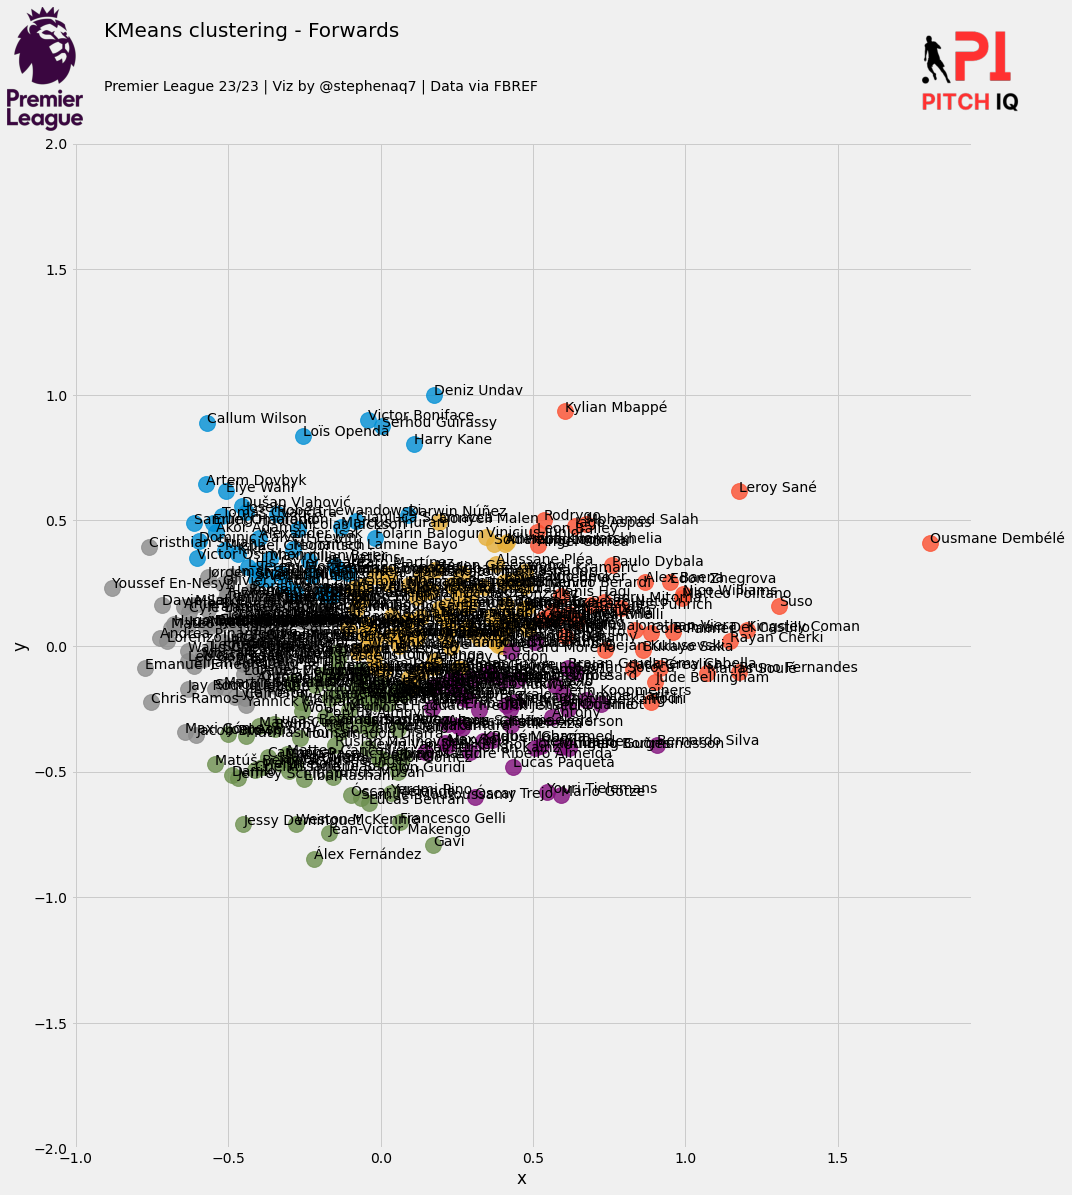

In [24]:
def creat_clustering_chart(df,position):
    # Create the scatter plot using lmplot
    ax = sns.lmplot(x="x", y="y", hue='cluster', data=df, legend=False,
                    fit_reg=False, size=15, scatter_kws={"s": 250})

    texts = []
    for x, y, s in zip(df.x, df.y, df.name):
        texts.append(plt.text(x, y, s,fontweight='light'))


    # Additional axes for logos and titles
    fig = plt.gcf()
    ax1 = plt.gca()

    # Add title and logos to the current figure
    fig.text(.1, 1.08, f'KMeans clustering - {position}', size=20, font='Karla')
    fig.text(.1, 1.03, 'Premier League 23/23 | Viz by @stephenaq7 | Data via FBREF', size=14, font='Karla')

    ax2 = fig.add_axes([0.01, 0.175, 0.07, 1.75])
    ax2.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png')
    ax2.imshow(img)

    ax3 = fig.add_axes([0.85, 0.175, 0.1, 1.75])
    ax3.axis('off')
    img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
    ax3.imshow(img)

    # Set axis limits and labels for the lmplot
    ax1.set(ylim=(-2, 2))
    plt.tick_params(labelsize=15)
    plt.xlabel("PC 1", fontsize=20)
    plt.ylabel("PC 2", fontsize=20)

    plt.tight_layout()
    plt.show()
    
creat_clustering_chart(kmeans_df,position)

In [27]:
def find_similar_players(player_name, df, top_n=10):
    player = df[df['name'] == player_name].iloc[0]
    df['distance'] = np.sqrt((df['x'] - player['x'])**2 + (df['y'] - player['y'])**2)
    
    max_distance = df['distance'].max()  
    
    df['perc_similarity'] = ((max_distance - df['distance']) / max_distance) * 100
    
    similar_players = df.sort_values('distance').head(top_n + 1)  
    similar_players = similar_players[1:] 
    
    return similar_players


In [28]:
similairty_table = find_similar_players(player_name, kmeans_df)[['name','perc_similarity']]


In [29]:
similairty_table.rename(columns={'name': 'Player'}, inplace=True)
# Assuming 'pitchiq_scores' and 'similarity' are the DataFrames and you want to merge based on the 'Player' column
mertrics_similarity = pd.merge(similairty_table, pitch_iq_scores, on='Player', how='left')


In [30]:
mertrics_similarity

Player  perc_similarity   Nation    Pos        Squad     Age  \
0       Harry Wilson        96.750802  wls WAL     FW       Fulham  26-264   
1        Aron Dønnum        93.736097   no NOR  FW,MF     Toulouse  25-235   
2       Václav Černý        93.589553   cz CZE  FW,MF    Wolfsburg  26-055   
3      Lucas Ocampos        92.783371   ar ARG     FW      Sevilla  29-153   
4        John McGinn        92.362718  sct SCO  MF,FW  Aston Villa  29-054   
5      Gerard Moreno        92.152115   es ESP  FW,MF   Villarreal  31-248   
6   Christian Kouamé        91.730702   ci CIV     FW   Fiorentina  26-005   
7              Sávio        91.527633   br BRA  MF,FW       Girona  19-245   
8  Christian Pulisic        90.288785   us USA  FW,MF        Milan  25-084   
9     Jonathan Bamba        89.711537   ci CIV  MF,FW   Celta Vigo  27-260   

  position_group   90s  Total - Cmp%        KP        TB        Sw       PPA  \
0       Forwards   9.3          77.7  1.075269  0.322581  0.430108  1.612903   
1       Forwards   8.2          76.1  1.951220  0.365854  0.975610  1.707317   
2       Forwards   6.0          68.5  1.333333  0.500000  0.333333  2.333333   
3       Forwards  12.7          64.9  1.259843  0.078740  0.551181  1.574803   
4       Forwards  15.0          77.8  1.600000  0.533333  0.333333  1.800000   
5       Forwards  11.9          78.2  1.932773  0.504202  0.420168  1.680672   
6       Forwards   5.1          77.0  1.176471  0.196078  0.196078  2.549020   
7       Forwards  14.5          76.0  1.448276  0.000000  0.275862  1.586207   
8       Forwards   9.8          78.7  1.530612  0.204082  0.102041  1.428571   
9       Forwards  14.0          75.6  1.714286  0.285714  0.142857  1.642857   

       PrgP  Tkl%  Total Blocks   Tkl+Int       Clr  Carries - PrgDist  SCA90  \
0  3.333333  54.5      1.290323  1.720430  0.215054          94.086022   3.57   
1  4.512195  25.0      0.975610  1.341463  0.975610         131.463415   3.53   
2  3.500000  11.1      1.333333  1.833333  0.666667          69.833333   3.51   
3  3.700787  42.9      1.102362  2.362205  0.393701         110.157480   3.70   
4  5.933333  33.3      0.733333  2.400000  0.333333          73.800000   3.87   
5  5.798319  50.0      1.008403  1.512605  1.008403          59.831933   3.52   
6  4.509804  66.7      1.764706  1.176471  0.784314          52.156863   3.52   
7  2.344828  53.8      1.379310  1.655172  0.344828         153.655172   3.44   
8  3.163265  62.5      0.714286  1.428571  0.306122         133.979592   3.17   
9  3.071429   0.0      1.071429  1.214286  0.642857         133.500000   4.28   

   GCA90     CrsPA        xA        Rec       PrgR        xG        Sh  \
0   0.76  0.430108  0.172043  35.483871   8.279570  0.172043  2.043011   
1   0.24  0.000000  0.231707  35.121951   7.317073  0.048780  1.219512   
2   0.33  0.166667  0.233333  29.833333   7.666667  0.183333  2.000000   
3   0.16  0.708661  0.110236  38.110236  10.629921  0.165354  2.677165   
4   0.53  0.333333  0.173333  29.466667   3.333333  0.140000  1.266667   
5   0.34  0.252101  0.210084  41.764706   6.806723  0.436975  2.436975   
6   0.39  0.196078  0.137255  41.764706  10.784314  0.156863  2.549020   
7   0.83  0.413793  0.358621  34.068966  11.034483  0.158621  1.172414   
8   0.82  0.510204  0.163265  37.040816   8.979592  0.234694  1.836735   
9   0.21  0.642857  0.164286  34.714286   8.571429  0.171429  2.071429   

        SoT  Passing_Score  Defending_Score  Creation_Score  Shooting_Score  
0  0.752688       7.698687         7.930025        7.734917        6.912820  
1  0.487805       7.365611         6.592099        6.335418        5.457788  
2  0.333333       6.678572         6.412659        6.097668        5.708459  
3  0.866142       6.878762         7.476003        7.282251        6.806231  
4  0.466667       7.744735         6.951733        6.593563        5.988831  
5  0.840336       7.876738         7.584391        6.853771        7.078154  
6  0.588235       7.1

In [31]:
comparative_list = list(mertrics_similarity.Player.unique())
sim_index = list(mertrics_similarity.perc_similarity.unique())
sim_index = [round(item, 2) for item in sim_index]


In [32]:
from mplsoccer import Radar, FontManager
import matplotlib.pyplot as plt

In [33]:
URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

In [34]:
params = ['Total - Cmp%','KP',
'PPA',
 'PrgP',
 'Tkl%',
 'Total Blocks',
 'Tkl+Int',
 'Clr',
 'Carries - PrgDist',
 'SCA90',
 'xA',
 'xG']

In [35]:
main_player = pitch_iq_scores[pitch_iq_scores['Player'] == player_name][params].values.tolist()
comp_player_1 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[0]][params].values.tolist()
comp_player_2 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[1]][params].values.tolist()
comp_player_3 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[2]][params].values.tolist()
comp_player_4 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[3]][params].values.tolist()
comp_player_5 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[4]][params].values.tolist()


main_player = [val for sublist in main_player for val in sublist]
comp_player_1 = [val for sublist in comp_player_1 for val in sublist]
comp_player_2 = [val for sublist in comp_player_2 for val in sublist]
comp_player_3 = [val for sublist in comp_player_3 for val in sublist]
comp_player_4 = [val for sublist in comp_player_4 for val in sublist]




findfont: Font family ['Karla'] not found. Falling back to DejaVu Sans.


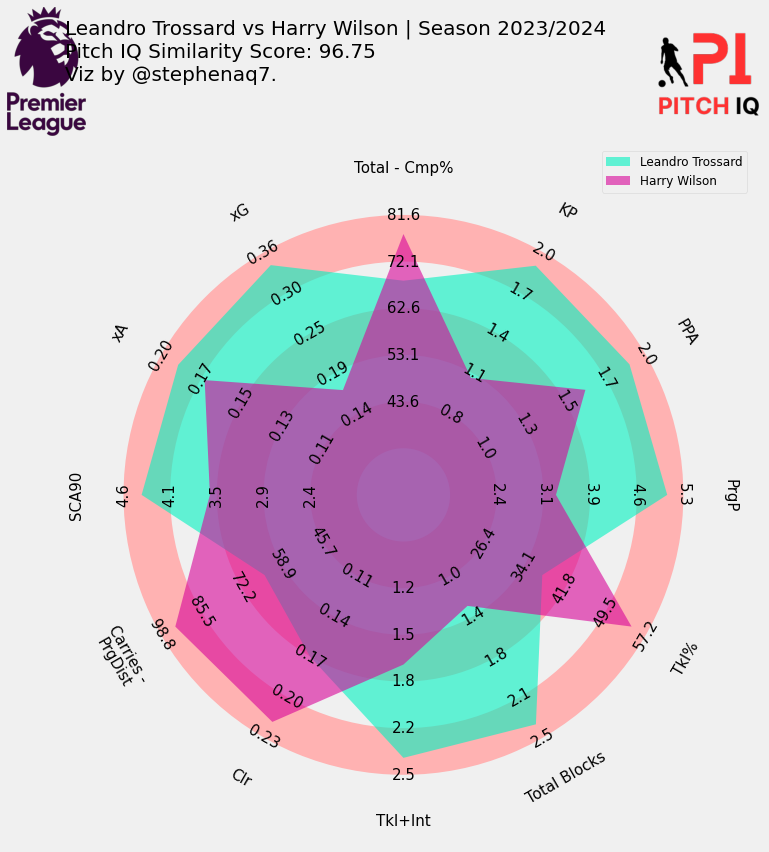

In [36]:

values = main_player
values_2 = comp_player_1

def convert_to_numeric(input_list):
    return [float(x) for x in input_list]  # Use int() instead of float() if integers are desired

# Convert string-based lists to numeric lists
numeric_values = convert_to_numeric(values)
numeric_comp_player_1 = convert_to_numeric(comp_player_1)

# Perform the calculations after converting to numeric lists
low = [min(value, value_2) * 0.5 for value, value_2 in zip(numeric_values, numeric_comp_player_1)]
high = [max(value, value_2) * 1.05 for value, value_2 in zip(numeric_values, numeric_comp_player_1)]

radar = Radar(params, low, high,
    
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=5,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)


fig, ax = radar.setup_axis()

fig.patch.set_facecolor('#f0f0f0')  # Adjust this color to match 'fivethirtyeight' style
ax.set_facecolor('#f0f0f0')  # Adjust axis background color to match the whitespace

rings_inner = radar.draw_circles(ax=ax, facecolor='#ffb2b2')
radar_output = radar.draw_radar_compare(values, values_2, ax=ax,
                                        kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                        kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
radar_poly, radar_poly2, vertices1, vertices2 = radar_output
range_labels = radar.draw_range_labels(ax=ax, fontsize=15,)
param_labels = radar.draw_param_labels(ax=ax, fontsize=15)

# Adding a legend for the radar comparison
ax.legend([f'{player_name}', comparative_list[0]], loc='upper right', fontsize=12)



# # ---- The Naught Boys Image
league_icon = Image.open("/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png")
league_ax = fig.add_axes([0.002, 0.89, 0.20, 0.15], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

fig_text(
    x = 0.75, y = 0.95, 
    s = f"{player_name} vs {comparative_list[0]} | Season 2023/2024\nPitch IQ Similarity Score: {sim_index[0]}\nViz by @stephenaq7.",
    va = "bottom", ha = "right",
    fontsize = 20, color = "black", font = "Karla", weight = "book"
)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.80, 0.09, 0.13, 1.75])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
ax3.imshow(img)

# Show the plot
plt.show()


In [37]:
def plot_compairison_radars(params,comparative_list,pitch_iq_scores,mertrics_similarity,sim_index):

    main_player = pitch_iq_scores[pitch_iq_scores['Player'] == player_name][params].values.tolist()
    comp_player_1 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[0]][params].values.tolist()
    comp_player_2 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[1]][params].values.tolist()
    comp_player_3 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[2]][params].values.tolist()
    comp_player_4 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[3]][params].values.tolist()
    comp_player_5 = mertrics_similarity[mertrics_similarity['Player'] == comparative_list[4]][params].values.tolist()


    main_player = [val for sublist in main_player for val in sublist]
    comp_player_1 = [val for sublist in comp_player_1 for val in sublist]
    comp_player_2 = [val for sublist in comp_player_2 for val in sublist]
    comp_player_3 = [val for sublist in comp_player_3 for val in sublist]
    comp_player_4 = [val for sublist in comp_player_4 for val in sublist]
    comp_player_5 = [val for sublist in comp_player_5 for val in sublist]

    all_comp_players = [comp_player_1,comp_player_2,comp_player_3,comp_player_4,comp_player_5]
    counter = 0
    for comp_player  in all_comp_players:
        
        values = main_player
        values_2 = comp_player

        def convert_to_numeric(input_list):
            return [float(x) for x in input_list]  # Use int() instead of float() if integers are desired

        # Convert string-based lists to numeric lists
        numeric_values = convert_to_numeric(values)
        numeric_comp_player_1 = convert_to_numeric(comp_player)

        # Perform the calculations after converting to numeric lists
        low = [min(value, value_2) * 0.5 for value, value_2 in zip(numeric_values, numeric_comp_player_1)]
        high = [max(value, value_2) * 1.05 for value, value_2 in zip(numeric_values, numeric_comp_player_1)]

        radar = Radar(params, low, high,
            
                    # whether to round any of the labels to integers instead of decimal places
                    round_int=[False]*len(params),
                    num_rings=5,  # the number of concentric circles (excluding center circle)
                    # if the ring_width is more than the center_circle_radius then
                    # the center circle radius will be wider than the width of the concentric circles
                    ring_width=1, center_circle_radius=1)


        fig, ax = radar.setup_axis()

        fig.patch.set_facecolor('#f0f0f0')  # Adjust this color to match 'fivethirtyeight' style
        ax.set_facecolor('#f0f0f0')  # Adjust axis background color to match the whitespace

        rings_inner = radar.draw_circles(ax=ax, facecolor='#ffb2b2')
        radar_output = radar.draw_radar_compare(values, values_2, ax=ax,
                                                kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6},
                                                kwargs_compare={f'facecolor': '#d80499', 'alpha': 0.6})
        radar_poly, radar_poly2, vertices1, vertices2 = radar_output
        range_labels = radar.draw_range_labels(ax=ax, fontsize=15,)
        param_labels = radar.draw_param_labels(ax=ax, fontsize=15)

        # Adding a legend for the radar comparison
        ax.legend([f'{player_name}', comparative_list[counter]], loc='upper right', fontsize=12)



        # # ---- The Naught Boys Image
        league_icon = Image.open("/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png")
        league_ax = fig.add_axes([0.002, 0.89, 0.20, 0.15], zorder=1)
        league_ax.imshow(league_icon)
        league_ax.axis("off")

        fig_text(
            x = 0.55, y = 0.90, 
            s = f"{player_name} vs {comparative_list[counter]}\nSeason 2023/2024\nPitch IQ Similarity Score: {sim_index[counter]}%\nViz by @stephenaq7.",
            va = "bottom", ha = "right",
            fontsize = 20, color = "black", font = "Karla", weight = "book"
        )


        ### Add Stats by Steve logo
        ax3 = fig.add_axes([0.80, 0.09, 0.13, 1.75])
        ax3.axis('off')
        img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
        ax3.imshow(img)
        counter += 1

        # Show the plot
        plt.show()


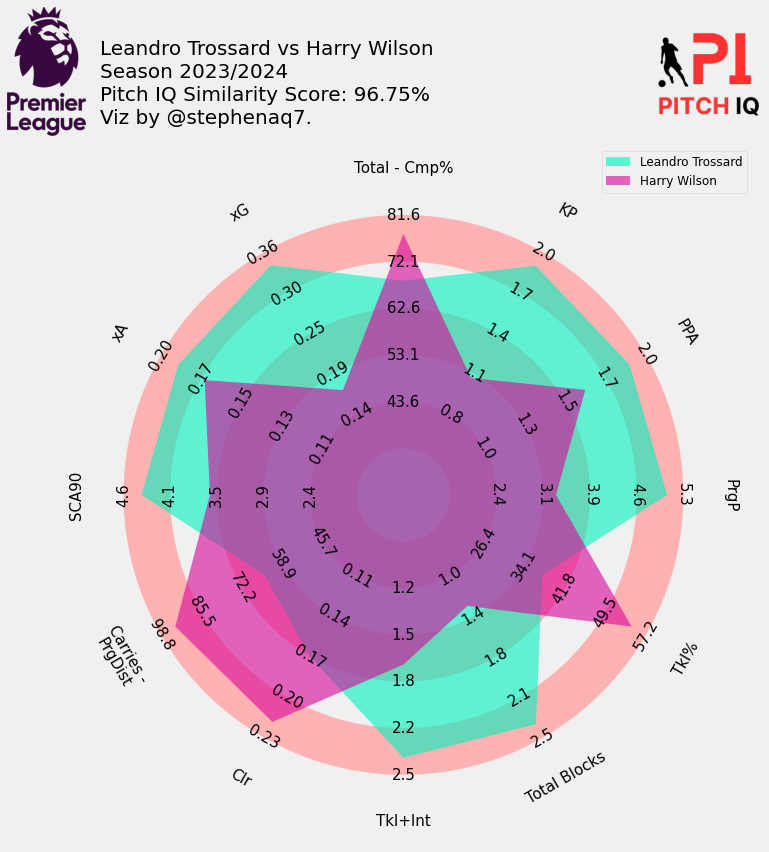

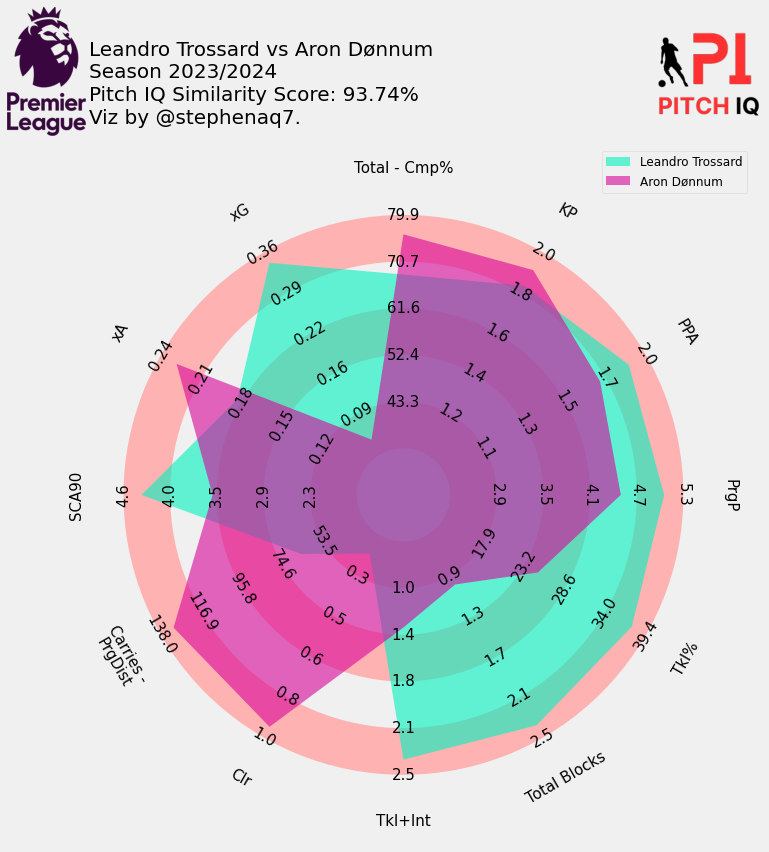

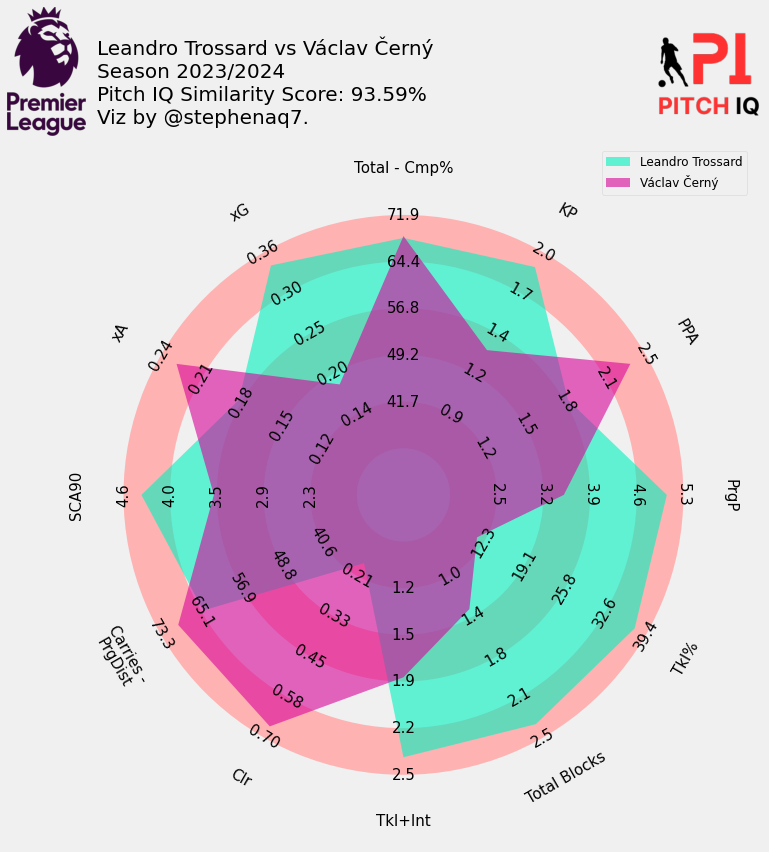

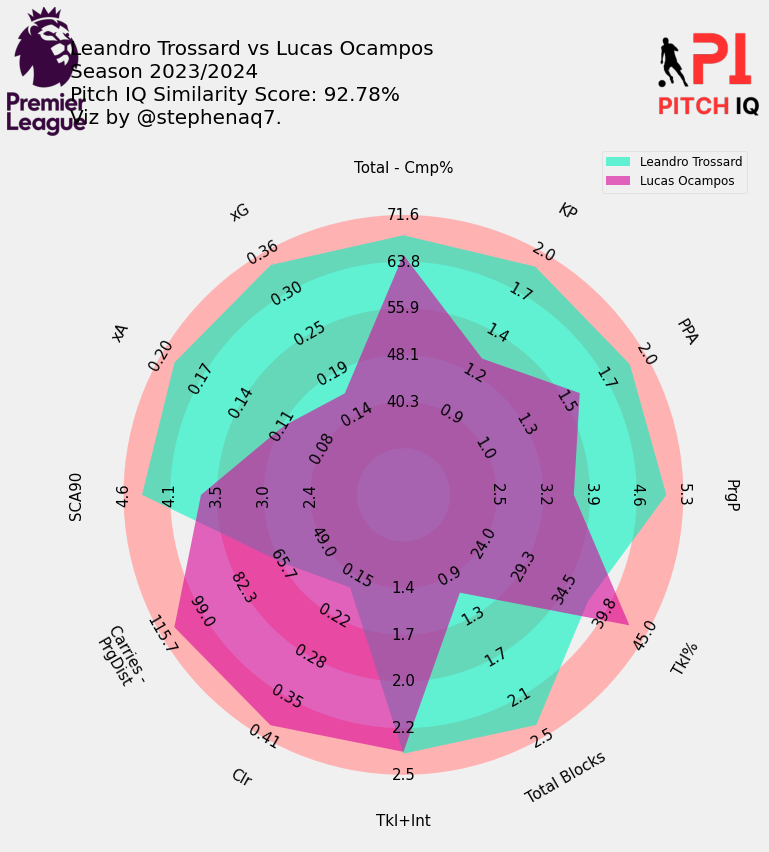

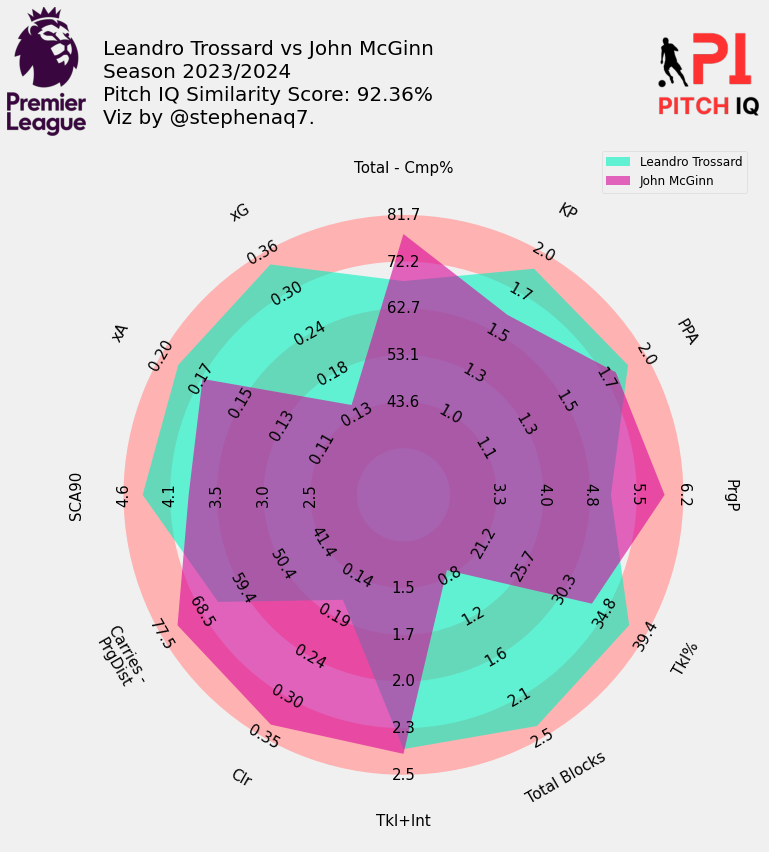

In [38]:
plot_compairison_radars(params,comparative_list,pitch_iq_scores,mertrics_similarity, sim_index)

In [39]:
mertrics_similarity

Player  perc_similarity   Nation    Pos        Squad     Age  \
0       Harry Wilson        96.750802  wls WAL     FW       Fulham  26-264   
1        Aron Dønnum        93.736097   no NOR  FW,MF     Toulouse  25-235   
2       Václav Černý        93.589553   cz CZE  FW,MF    Wolfsburg  26-055   
3      Lucas Ocampos        92.783371   ar ARG     FW      Sevilla  29-153   
4        John McGinn        92.362718  sct SCO  MF,FW  Aston Villa  29-054   
5      Gerard Moreno        92.152115   es ESP  FW,MF   Villarreal  31-248   
6   Christian Kouamé        91.730702   ci CIV     FW   Fiorentina  26-005   
7              Sávio        91.527633   br BRA  MF,FW       Girona  19-245   
8  Christian Pulisic        90.288785   us USA  FW,MF        Milan  25-084   
9     Jonathan Bamba        89.711537   ci CIV  MF,FW   Celta Vigo  27-260   

  position_group   90s  Total - Cmp%        KP        TB        Sw       PPA  \
0       Forwards   9.3          77.7  1.075269  0.322581  0.430108  1.612903   
1       Forwards   8.2          76.1  1.951220  0.365854  0.975610  1.707317   
2       Forwards   6.0          68.5  1.333333  0.500000  0.333333  2.333333   
3       Forwards  12.7          64.9  1.259843  0.078740  0.551181  1.574803   
4       Forwards  15.0          77.8  1.600000  0.533333  0.333333  1.800000   
5       Forwards  11.9          78.2  1.932773  0.504202  0.420168  1.680672   
6       Forwards   5.1          77.0  1.176471  0.196078  0.196078  2.549020   
7       Forwards  14.5          76.0  1.448276  0.000000  0.275862  1.586207   
8       Forwards   9.8          78.7  1.530612  0.204082  0.102041  1.428571   
9       Forwards  14.0          75.6  1.714286  0.285714  0.142857  1.642857   

       PrgP  Tkl%  Total Blocks   Tkl+Int       Clr  Carries - PrgDist  SCA90  \
0  3.333333  54.5      1.290323  1.720430  0.215054          94.086022   3.57   
1  4.512195  25.0      0.975610  1.341463  0.975610         131.463415   3.53   
2  3.500000  11.1      1.333333  1.833333  0.666667          69.833333   3.51   
3  3.700787  42.9      1.102362  2.362205  0.393701         110.157480   3.70   
4  5.933333  33.3      0.733333  2.400000  0.333333          73.800000   3.87   
5  5.798319  50.0      1.008403  1.512605  1.008403          59.831933   3.52   
6  4.509804  66.7      1.764706  1.176471  0.784314          52.156863   3.52   
7  2.344828  53.8      1.379310  1.655172  0.344828         153.655172   3.44   
8  3.163265  62.5      0.714286  1.428571  0.306122         133.979592   3.17   
9  3.071429   0.0      1.071429  1.214286  0.642857         133.500000   4.28   

   GCA90     CrsPA        xA        Rec       PrgR        xG        Sh  \
0   0.76  0.430108  0.172043  35.483871   8.279570  0.172043  2.043011   
1   0.24  0.000000  0.231707  35.121951   7.317073  0.048780  1.219512   
2   0.33  0.166667  0.233333  29.833333   7.666667  0.183333  2.000000   
3   0.16  0.708661  0.110236  38.110236  10.629921  0.165354  2.677165   
4   0.53  0.333333  0.173333  29.466667   3.333333  0.140000  1.266667   
5   0.34  0.252101  0.210084  41.764706   6.806723  0.436975  2.436975   
6   0.39  0.196078  0.137255  41.764706  10.784314  0.156863  2.549020   
7   0.83  0.413793  0.358621  34.068966  11.034483  0.158621  1.172414   
8   0.82  0.510204  0.163265  37.040816   8.979592  0.234694  1.836735   
9   0.21  0.642857  0.164286  34.714286   8.571429  0.171429  2.071429   

        SoT  Passing_Score  Defending_Score  Creation_Score  Shooting_Score  
0  0.752688       7.698687         7.930025        7.734917        6.912820  
1  0.487805       7.365611         6.592099        6.335418        5.457788  
2  0.333333       6.678572         6.412659        6.097668        5.708459  
3  0.866142       6.878762         7.476003        7.282251        6.806231  
4  0.466667       7.744735         6.951733        6.593563        5.988831  
5  0.840336       7.876738         7.584391        6.853771        7.078154  
6  0.588235       7.1

In [40]:
mertrics_similarity = mertrics_similarity.rename(columns={'Squad': 'team'})
fm_ids = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
fm_ids = fm_ids[["team", "team_id"]]

mertrics_similarity = mertrics_similarity.merge(fm_ids, on='team', how='left')

mertrics_similarity

Player  perc_similarity   Nation    Pos         team     Age  \
0       Harry Wilson        96.750802  wls WAL     FW       Fulham  26-264   
1        Aron Dønnum        93.736097   no NOR  FW,MF     Toulouse  25-235   
2       Václav Černý        93.589553   cz CZE  FW,MF    Wolfsburg  26-055   
3      Lucas Ocampos        92.783371   ar ARG     FW      Sevilla  29-153   
4        John McGinn        92.362718  sct SCO  MF,FW  Aston Villa  29-054   
5      Gerard Moreno        92.152115   es ESP  FW,MF   Villarreal  31-248   
6   Christian Kouamé        91.730702   ci CIV     FW   Fiorentina  26-005   
7              Sávio        91.527633   br BRA  MF,FW       Girona  19-245   
8  Christian Pulisic        90.288785   us USA  FW,MF        Milan  25-084   
9     Jonathan Bamba        89.711537   ci CIV  MF,FW   Celta Vigo  27-260   

  position_group   90s  Total - Cmp%        KP        TB        Sw       PPA  \
0       Forwards   9.3          77.7  1.075269  0.322581  0.430108  1.612903   
1       Forwards   8.2          76.1  1.951220  0.365854  0.975610  1.707317   
2       Forwards   6.0          68.5  1.333333  0.500000  0.333333  2.333333   
3       Forwards  12.7          64.9  1.259843  0.078740  0.551181  1.574803   
4       Forwards  15.0          77.8  1.600000  0.533333  0.333333  1.800000   
5       Forwards  11.9          78.2  1.932773  0.504202  0.420168  1.680672   
6       Forwards   5.1          77.0  1.176471  0.196078  0.196078  2.549020   
7       Forwards  14.5          76.0  1.448276  0.000000  0.275862  1.586207   
8       Forwards   9.8          78.7  1.530612  0.204082  0.102041  1.428571   
9       Forwards  14.0          75.6  1.714286  0.285714  0.142857  1.642857   

       PrgP  Tkl%  Total Blocks   Tkl+Int       Clr  Carries - PrgDist  SCA90  \
0  3.333333  54.5      1.290323  1.720430  0.215054          94.086022   3.57   
1  4.512195  25.0      0.975610  1.341463  0.975610         131.463415   3.53   
2  3.500000  11.1      1.333333  1.833333  0.666667          69.833333   3.51   
3  3.700787  42.9      1.102362  2.362205  0.393701         110.157480   3.70   
4  5.933333  33.3      0.733333  2.400000  0.333333          73.800000   3.87   
5  5.798319  50.0      1.008403  1.512605  1.008403          59.831933   3.52   
6  4.509804  66.7      1.764706  1.176471  0.784314          52.156863   3.52   
7  2.344828  53.8      1.379310  1.655172  0.344828         153.655172   3.44   
8  3.163265  62.5      0.714286  1.428571  0.306122         133.979592   3.17   
9  3.071429   0.0      1.071429  1.214286  0.642857         133.500000   4.28   

   GCA90     CrsPA        xA        Rec       PrgR        xG        Sh  \
0   0.76  0.430108  0.172043  35.483871   8.279570  0.172043  2.043011   
1   0.24  0.000000  0.231707  35.121951   7.317073  0.048780  1.219512   
2   0.33  0.166667  0.233333  29.833333   7.666667  0.183333  2.000000   
3   0.16  0.708661  0.110236  38.110236  10.629921  0.165354  2.677165   
4   0.53  0.333333  0.173333  29.466667   3.333333  0.140000  1.266667   
5   0.34  0.252101  0.210084  41.764706   6.806723  0.436975  2.436975   
6   0.39  0.196078  0.137255  41.764706  10.784314  0.156863  2.549020   
7   0.83  0.413793  0.358621  34.068966  11.034483  0.158621  1.172414   
8   0.82  0.510204  0.163265  37.040816   8.979592  0.234694  1.836735   
9   0.21  0.642857  0.164286  34.714286   8.571429  0.171429  2.071429   

        SoT  Passing_Score  Defending_Score  Creation_Score  Shooting_Score  \
0  0.752688       7.698687         7.930025        7.734917        6.912820   
1  0.487805       7.365611         6.592099        6.335418        5.457788   
2  0.333333       6.678572         6.412659        6.097668        5.708459   
3  0.866142       6.878762         7.476003        7.282251        6.806231   
4  0.466667       7.744735         6.951733        6.593563        5.988831   
5  0.840336       7.876738         7.584391        6.853771        7.078154   
6  0.588235   

In [41]:
mertrics_similarity[['perc_similarity', 'Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']] = \
    mertrics_similarity[['perc_similarity', 'Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']].round(2)

# Storing the rounded values in df_final
df_final = mertrics_similarity[['Player', 'Pos','team_id','perc_similarity', 'Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']]
metric_scores =['Passing_Score', 'Defending_Score', 'Creation_Score', 'Shooting_Score']

sim_player_vals = pitch_iq_scores[pitch_iq_scores['Player'] == player_name][metric_scores].values.tolist()

sim_player_vals = [val for sublist in sim_player_vals for val in sublist]
df_final['Δ% Passing'] = ((sim_player_vals[0] - df_final['Passing_Score'] ) / df_final['Passing_Score']).round(1) *100
df_final['Δ% Defending'] = ((sim_player_vals[1] - df_final['Defending_Score']) / df_final['Passing_Score']).round(1)*100
df_final['Δ% Creation'] = ((sim_player_vals[2] - df_final['Creation_Score']) / df_final['Passing_Score']).round(1)*100
df_final['Δ% Shooting'] = ((sim_player_vals[3] - df_final['Shooting_Score']) / df_final['Passing_Score']).round(1)*100
df_final = df_final[::-1]


/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [42]:
sim_player = pitch_iq_scores[pitch_iq_scores['Player'] == player_name][metric_scores]
sim_player

Passing_Score  Defending_Score  Creation_Score  Shooting_Score
345        7.75648         8.423585        7.257708        7.585903

In [43]:
def perc_battery(perc_similarity, ax):
    '''
    This function takes an integer and an axes and 
    plots a battery chart.
    '''
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.barh([0.5], [1], fc = 'white', ec='black', height=.35)
    ax.barh([0.5], [perc_similarity/100], fc = '#00529F', height=.35)
    text_ = ax.annotate(
        xy=((perc_similarity/100), .5),
        text=f'{(perc_similarity/100):.0%}',
        xytext=(-8,0),
        textcoords='offset points',
        weight='bold',
        color='#EFE9E6',
        va='center',
        ha='center',
        size=8
    )
    ax.set_axis_off()
    return ax

def ax_logo(team_id, ax):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

HTTPError: HTTP Error 403: Forbidden

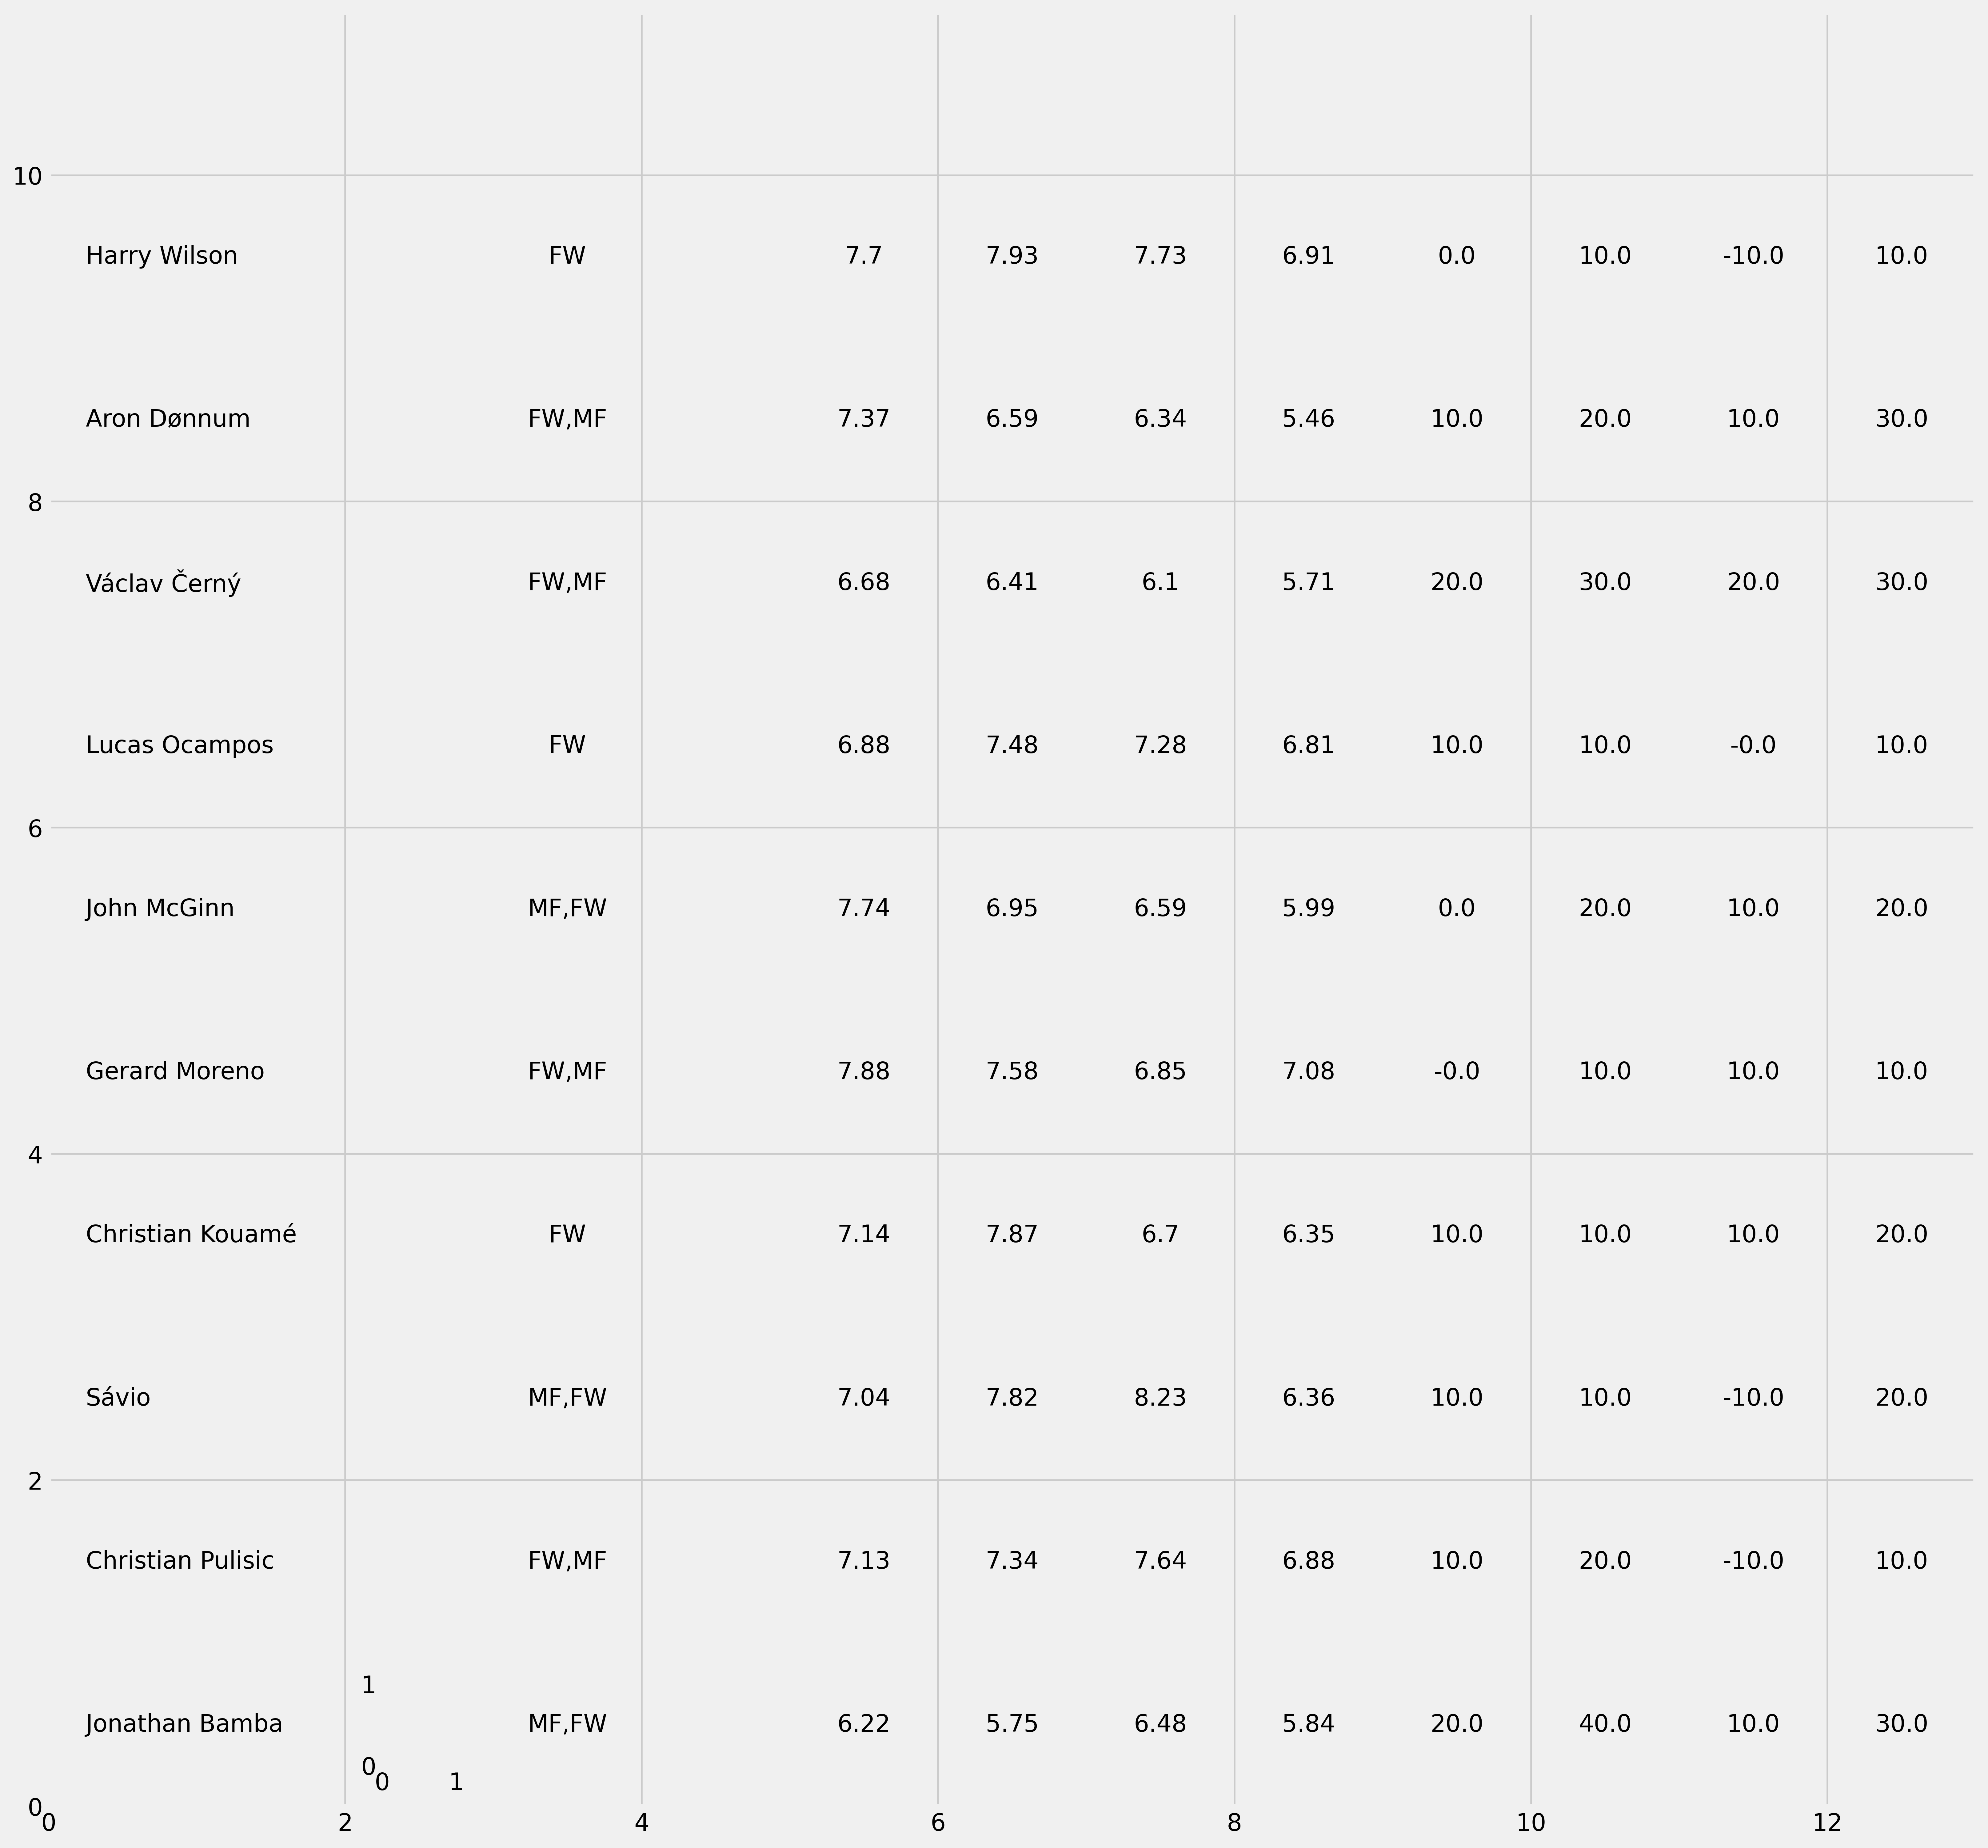

In [44]:
fig = plt.figure(figsize=(18,18), dpi=400)
ax = plt.subplot()

ncols = 12
nrows = df_final.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.25, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]
columns = ['Player', 'Pos', 'perc_similarity', 'Passing_Score', 'Defending_Score',	'Creation_Score', 'Shooting_Score','Δ% Passing','Δ% Defending','Δ% Creation','Δ% Shooting']

# -- Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'perc_similarity':
            continue
        else:
            text_label = f'{df_final[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([2.25, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(df_final['team_id'].iloc[x], flag_ax)

ax_point_1 = DC_to_NFC([4, 0.05])
ax_point_2 = DC_to_NFC([5, 0.95])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([4, x + .025])
    bar_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    perc_battery(df_final['perc_similarity'].iloc[x], bar_ax)

# -- Add column names
column_names = ['Player', 'Position', 'Percent\nSimilarity','Passing', 'Defending',	'Creation', 'Shooting','Δ%\nPassing','Δ%\nDefending','Δ%\nCreation','Δ%\nShooting']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='book'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.fill_between(
    x=[0,2],
    y1=nrows,
    y2=0,
    color='lightgrey',
    alpha=0.5,
    ec='None'
)

ax.fill_between(
    x=[9,14],
    y1=nrows,
    y2=0,
    color='green',
    alpha=0.2,
    ec='None'
)

ax.set_axis_off()
# -- Final details
league_icon = Image.open("/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png")
league_ax = fig.add_axes([0.04, 0.82, 0.15, 0.11], zorder=1)
league_ax.imshow(league_icon)
league_ax.axis("off")

ax.tick_params(axis='both', which='major', labelsize=8)

fig_text(
     x = 0.52, y = 0.91, 
    s = f'{player_name} - PIQ Similarity Model Results 23/24',
    va = "bottom", ha = "right",
    fontsize = 17, color = "black", font = "Karla", weight = "bold"
)

fig_text(
     x = 0.48, y = 0.87, 
    s = f'Passing, Defending, Creation & Shooting\nscores genrated via weighted aggregated metrics from FBREF',
    va = "bottom", ha = "right",
    fontsize = 13, color = "black", font = "Karla", weight = "book"
)
fig_text(
     x = 0.48, y = 0.85, 
    s = f'Δ% columns are PIQ score percentage change vs {player_name}',
    va = "bottom", ha = "right",
    fontsize = 13, color = "black", font = "Karla", weight = "book"
)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.83, 0.08, 0.10, 1.60])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
ax3.imshow(img)


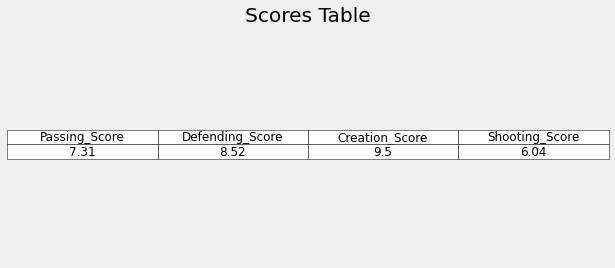

In [ ]:
sim_player = pitch_iq_scores[pitch_iq_scores['Player'] == player_name][metric_scores]
sim_player[metric_scores] = \
    sim_player[metric_scores].round(2)

fig, ax = plt.subplots(figsize=(8, 4))


ax.axis('off')  # Hide the axes
tbl = ax.table(cellText=sim_player.values, colLabels=sim_player.columns, loc='center', cellLoc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)  # Adjust the table size if needed

plt.title('Scores Table')
plt.show()

In [379]:
# write up needed 